In [ ]:
from visual_behavior_glm.src.glm import GLM
import visual_behavior_glm.src.GLM_fit_tools as gft
import visual_behavior_glm.src.GLM_analysis_tools as gat
import visual_behavior_glm.src.GLM_visualization_tools as gvt

import visual_behavior.utilities as vbu
import visual_behavior.plotting as vbp
import visual_behavior.data_access.loading as loading
import visual_behavior.visualization.utils as vis_utils
import visual_behavior.database as db

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import scikit_posthocs

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%widescreen

# Collect cached results from mongodb

In [41]:
conn = db.Database('visual_behavior_data')
database = 'ophys_glm'
results_full = pd.DataFrame(list(conn[database]['results_full'].find({'glm_version':2})))
results_summary = pd.DataFrame(list(conn[database]['results_summary'].find({'glm_version':2})))

In [42]:
results_full.sample(5)

,_id,cell_specimen_id,Full_avg_cv_var_train,Full_avg_cv_var_test,intercept_avg_cv_var_train,intercept_avg_cv_var_test,time_avg_cv_var_train,time_avg_cv_var_test,pre_licks_avg_cv_var_train,pre_licks_avg_cv_var_test,post_licks_avg_cv_var_train,post_licks_avg_cv_var_test,rewards_avg_cv_var_train,rewards_avg_cv_var_test,change_avg_cv_var_train,change_avg_cv_var_test,omissions_avg_cv_var_train,omissions_avg_cv_var_test,running_avg_cv_var_train,running_avg_cv_var_test,pupil_avg_cv_var_train,pupil_avg_cv_var_test,image0_avg_cv_var_train,image0_avg_cv_var_test,image1_avg_cv_var_train,image1_avg_cv_var_test,image2_avg_cv_var_train,image2_avg_cv_var_test,image3_avg_cv_var_train,image3_avg_cv_var_test,image4_avg_cv_var_train,image4_avg_cv_var_test,image5_avg_cv_var_train,image5_avg_cv_var_test,image6_avg_cv_var_train,image6_avg_cv_var_test,image7_avg_cv_var_train,image7_avg_cv_var_test,model_bias_avg_cv_var_train,model_bias_avg_cv_var_test,model_task0_avg_cv_var_train,model_task0_avg_cv_var_test,model_omissions1_avg_cv_var_train,model_omissions1_avg_cv_var_test,model_timing1D_avg_cv_var_train,model_timing1D_avg_cv_var_test,all-images_avg_cv_var_train,all-images_avg_cv_var_test,visual_avg_cv_var_train,visual_avg_cv_var_test,beh_model_avg_cv_var_train,beh_model_avg_cv_var_test,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,entry_time_utc,glm_version
13709,5ee863b594ac8f0af16c9079,1007031577,0.013266,-0.007262,0.013265,-0.007249,0.013265,-0.007240,0.012984,-0.007163,0.012832,-0.006872,0.011722,-0.005791,0.011900,-0.005782,0.012543,-0.006498,0.012411,-0.006716,0.012275,-0.006275,0.012457,-0.007064,0.012712,-0.006764,0.012618,-0.006830,0.012723,-0.006605,0.012674,-0.006925,0.012499,-0.006925,0.012575,-0.006831,0.012607,-0.007000,0.013259,-0.007287,0.013259,-0.007260,0.013254,-0.007291,0.013258,-0.007343,0.007809,-0.004284,0.006856,-0.003723,0.013114,-0.007268,940852658,940446507,940553228,930022332,VisualBehavior,container_qc,passed,20190906_459777_3ImagesA,OPHYS_3_images_A,CAM2P.3,2019-09-06 15:20:35.000000,863814878,854625263,F,182.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,854625263,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,2020-06-16 07:13:08.611947,2
16955,5ee864f2f568f391bb40e641,1018033754,0.078468,0.007943,0.078453,0.007972,0.077902,0.007910,0.077546,0.007423,0.077309,0.006805,0.074492,0.007077,0.074721,0.008502,0.077641,0.008945,0.073192,0.005793,0.068102,0.030836,0.076821,0.005719,0.077557,0.007547,0.077553,0.006994,0.074786,0.002292,0.076070,0.005447,0.077403,0.006673,0.077329,0.008277,0.077812,0.009175,0.078032,0.006873,0.078456,0.007969,0.078408,0.008513,0.078261,0.008020,0.062535,-0.001248,0.059286,-0.002829,0.077297,0.007825,877669811,873247524,873517635,1018027599,VisualBehaviorMultiscope,completed,passed,20190522_449653_Ophys4,OPHYS_4_images_B,MESO.1,2019-05-22 08:08:26.000000,846102910,837628436,M,124.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],225,VISp,NaN,837628436,Vip-IRES-Cre,NaN,NaN,0,1,Vip_VISp_225,2020-06-16 07:44:05.854284,2
7611,5ee860fc3b32482115645c44,1028759002,0.026766,0.006666,0.026742,0.006665,0.026700,0.006700,0.026600,0.006927,0.026140,0.006640,0.025652,0.007720,0.024679,0.006982,0.025582,0.006834,0.025405,0.006836,0.026240,0.008118,0.026256,0.007226,0.025386,0.006305,0.026177,0.007460,0.026014,0.006974,0.025720,0.006598,0.026169,0.006830,0.021409,0.002917,0.026136,0.007166,0.026735,0.006619,0.026653,0.006486,0.026762,0.006669,0.026751,0.006674,0.014237,0.003612,0.012215,0.002941,0.026573,0.0065

# get the experiments table

In [4]:
experiments_table = loading.get_filtered_ophys_experiment_table()
len(experiments_table)

1464

# basic exploration

In [5]:
experiments_table['targeted_structure'].value_counts()

VISp     818
VISl     469
VISam     91
VISal     86
Name: targeted_structure, dtype: int64

In [6]:
experiments_table['cre_line'].value_counts()

Slc17a7-IRES2-Cre    688
Vip-IRES-Cre         519
Sst-IRES-Cre         257
Name: cre_line, dtype: int64

## apply a threshold on variance explained (assign to a boolean column called `above_CV_threshold`)

In [7]:
results_full['above_CV_threshold'] = results_full['Full_avg_cv_var_test'].map(lambda CV: CV>=0.01)

In [8]:
results_summary = results_summary.merge(
    results_full[['ophys_experiment_id','cell_specimen_id','above_CV_threshold']],
    left_on = ['ophys_experiment_id','cell_specimen_id'],
    right_on = ['ophys_experiment_id','cell_specimen_id'],
    how='left'
)

In [9]:
results_summary.sample(5)

,_id,dropout,variance_explained,fraction_change_from_full,absolute_change_from_full,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,entry_time_utc,above_CV_threshold
544112,5ee8b950f3ec8fab23430f41,image5,0.197242,-0.010791,-0.002152,1028793300,906910612,906521029,906658064,1018027650,VisualBehaviorMultiscope,completed,passed,20190715_456915_Ophys4,OPHYS_4_images_B,MESO.1,2019-07-15 11:15:20.640855,852260338,843122504,F,144.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",275,VISp,NaN,843122504,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_275,2020-06-16 12:21:34.761303,True
551702,5ee8baed3f7870ae400b45dc,beh_model,-0.000721,-0.390633,0.000462,962555297,908350502,907757569,908065760,895259496,VisualBehaviorTask1B,container_qc,passed,20190717_461946_6imagesAretake,OPHYS_6_images_A,CAM2P.5,2019-07-17 15:48:21.000000,872873989,862671211,F,120.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,862671211,Slc17a7-IRES2-Cre,NaN,NaN,1,1,Slc17a7_VISp_175,2020-06-16 12:28:28.190511,False
214326,5ee867448fff8db243e03868,image6,-0.004488,-0.049080,0.000232,962554530,822647135,822388759,822439453,812858755,VisualBehavior,container_qc,passed,20190213_431023_VISp_175um_1a,OPHYS_1_images_A,CAM2P.5,2019-02-13 21:33:38.000000,796874559,789992909,M,111.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,789992909,Slc17a7-IRES2-Cre,NaN,NaN,2,1,Slc17a7_VISp_175,2020-06-16 08:24:26.470161,False
57768,5ee86049903bce3e2ecf4aa1,intercept,0.011179,-0.000826,-0.000009,1028781022,904363923,903621170,903708760,1018027878,VisualBehaviorMultiscope,completed,passed,20190711_453911_1imagesA,OPHYS_1_images_A,MESO.1,2019-07-11 08:06:16.364510,848541804,840390377,M,153.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,840390377,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,2020-06-16 07:06:32.865700,True
422988,5ee8a245d0bddca09730afe0,Full,0.015279,0.000000,0.000000,962641182,807753334,807393193,807584876,803589437,VisualBehavior,container_qc,passed,20190111_425496,OPHYS_3_images_A,CAM2P.4,2019-01-11 20:25:35.000000,781470340,772622653,M,108.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,772622653,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,2020-06-16 10:43:07.693174,True


In [10]:
len(results_full['ophys_experiment_id'].unique())

611

In [11]:
len(results_summary['ophys_experiment_id'].unique())

611

In [12]:
results_summary.sample(5)

,_id,dropout,variance_explained,fraction_change_from_full,absolute_change_from_full,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,entry_time_utc,above_CV_threshold
434,5ee82ca7275128047b0d958c,pupil,0.423567,0.000159,0.000067,962573914,833629926,833002992,833100683,829561794,VisualBehavior,container_qc,passed,20190306_431252_3imageA,OPHYS_3_images_A,CAM2P.4,2019-03-06 18:02:49.000000,792314934,784057626,F,139.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",375,VISp,NaN,784057626,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_375,2020-06-16 08:05:06.604719,True
163755,5ee86411e99526eab5513ed6,model_omissions1,-0.004435,-0.002159,0.000010,1028762516,882551956,882386411,882446265,1018027546,VisualBehaviorMultiscope,completed,passed,20190606_451787_3imagesA_2,OPHYS_3_images_A,MESO.1,2019-06-06 13:37:46.000000,846136902,837581585,M,127.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",150,VISp,NaN,837581585,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_150,2020-06-16 07:41:30.483792,False
512000,5ee8b2bb579789211708b497,image0,0.082398,-0.011108,-0.000926,1028811771,974994095,974486549,974634733,1018027831,VisualBehaviorMultiscope,completed,passed,20191031_484627_Ophys6,OPHYS_6_images_B,MESO.1,2019-10-31 08:26:06.328780,943395690,930825455,M,115.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",369,VISp,NaN,930825455,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_369,2020-06-16 11:53:28.100649,True
129190,5ee86264a64f2d12687d13a1,image4,0.253403,-0.131860,-0.038489,982825855,978827848,978361838,978647080,975371413,VisualBehaviorTask1B,holding,passed,20191108_477202_1imagesB,OPHYS_1_images_B,CAM2P.3,2019-11-08 17:12:06.000000,918315422,910248639,M,159.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,910248639,Sst-IRES-Cre,NaN,NaN,1,1,Sst_VISp_275,2020-06-16 07:08:59.343251,True
94973,5ee8612fe049383f2bc64e62,model_timing1D,-0.003602,-0.104688,0.000421,1018094653,888876943,888009781,888127012,1018028374,VisualBehaviorMultiscope,completed,passed,20190617_435431_stimulus6,OPHYS_4_images_B,MESO.1,2019-06-17 10:26:35.076547,815343876,807248992,M,213.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],274,VISp,NaN,807248992,Vip-IRES-Cre,NaN,z_drift_corr_um_diff,3,1,Vip_VISp_274,2020-06-16 07:08:37.975111,False


## organize some things

In [13]:
results_summary.dropout.unique()

array(['Full', 'intercept', 'time', 'pre_licks', 'post_licks', 'rewards',
       'change', 'omissions', 'running', 'pupil', 'image0', 'image1',
       'image2', 'image3', 'image4', 'image5', 'image6', 'image7',
       'model_bias', 'model_task0', 'model_omissions1', 'model_timing1D',
       'all-images', 'visual', 'beh_model'], dtype=object)

### for clarity, exclude the individual image kernels from plots

In [14]:
kernels_to_exclude = [k for k in results_summary.dropout.unique() if k.startswith('image')]
kernels_to_exclude

['image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7']

## clip the variance explained at reasonable limits. Can be either +/- 1 or -1 to 0

In [15]:
results_summary['clipped_fraction_change'] = results_summary['fraction_change_from_full'].map(lambda f:np.clip(f,-1,1))
results_summary['clipped_fraction_change_negative_only'] = results_summary['fraction_change_from_full'].map(lambda f:np.clip(f,-1,0))

In [16]:
fraction_change_order = results_summary.query('above_CV_threshold').groupby('dropout')['clipped_fraction_change'].mean().sort_values(ascending=False).index
fraction_change_order_negative_only = results_summary.query('above_CV_threshold').groupby('dropout')['clipped_fraction_change_negative_only'].mean().sort_values(ascending=False).index

In [17]:
fraction_change_order_limited = [k for k in fraction_change_order if k not in kernels_to_exclude]
fraction_change_order_negative_only_limited = [k for k in fraction_change_order_negative_only if k not in kernels_to_exclude]

## start making some plots!

In [18]:
genotype_order = ['Slc17a7-IRES2-Cre', 'Vip-IRES-Cre', 'Sst-IRES-Cre']

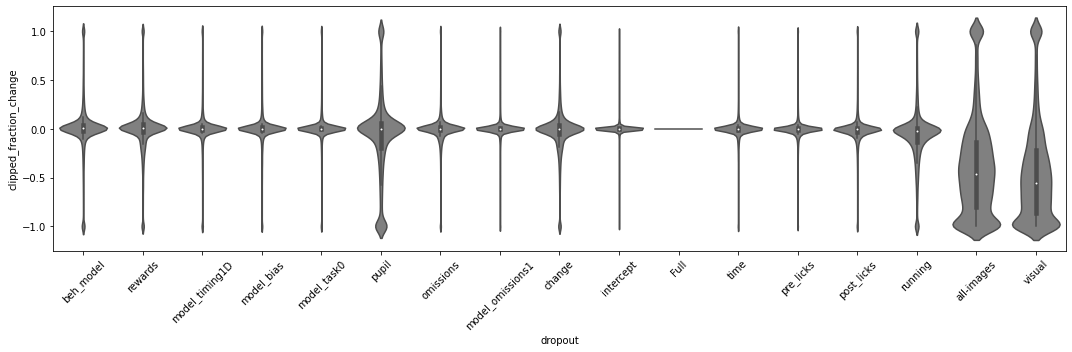

In [19]:
fig,ax=plt.subplots(figsize=(15,5))
vp = sns.violinplot(
    data = results_summary.query('dropout not in @kernels_to_exclude'),
    x = 'dropout',
    y = 'clipped_fraction_change',
    order=fraction_change_order_limited,
    scale='width',
    ax=ax,
    color='gray'
)
vp.set_xticklabels(labels=fraction_change_order_limited, rotation=45)
fig.tight_layout()

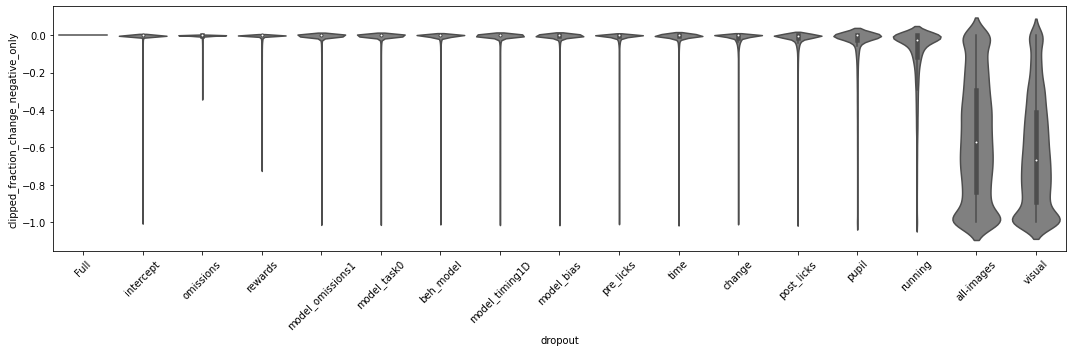

In [20]:
fig,ax=plt.subplots(figsize=(15,5))
vp = sns.violinplot(
    data = results_summary.query('above_CV_threshold'),
    x = 'dropout',
    y = 'clipped_fraction_change_negative_only',
    order=fraction_change_order_negative_only_limited,
    scale='width',
    ax=ax,
    color='gray'
)
vp.set_xticklabels(labels=fraction_change_order_negative_only_limited, rotation=45)
fig.tight_layout()

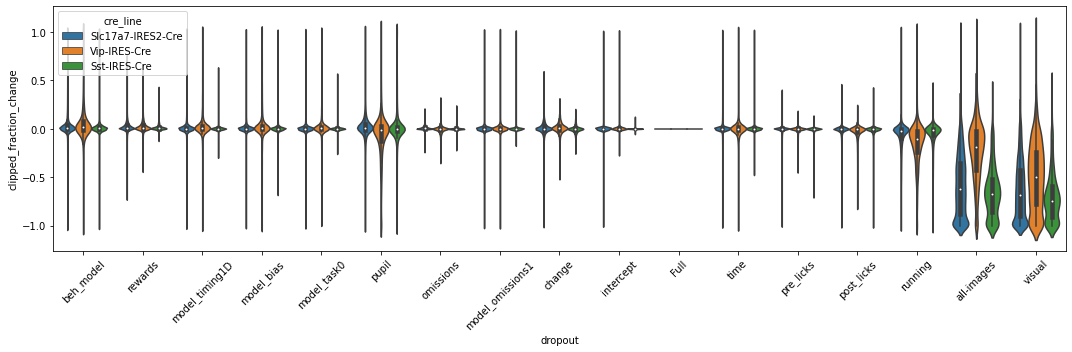

In [21]:
fig,ax=plt.subplots(figsize=(15,5))
vp = sns.violinplot(
    data = results_summary.query('dropout not in @kernels_to_exclude and above_CV_threshold'),
    x = 'dropout',
    y = 'clipped_fraction_change',
    order=fraction_change_order_limited,
    hue='cre_line',
    scale='width',
    ax=ax
)
vp.set_xticklabels(labels=fraction_change_order_limited, rotation=45)
fig.tight_layout()

In [22]:
results_full['above_CV_threshold'].value_counts()

True     20503
False    13708
Name: above_CV_threshold, dtype: int64

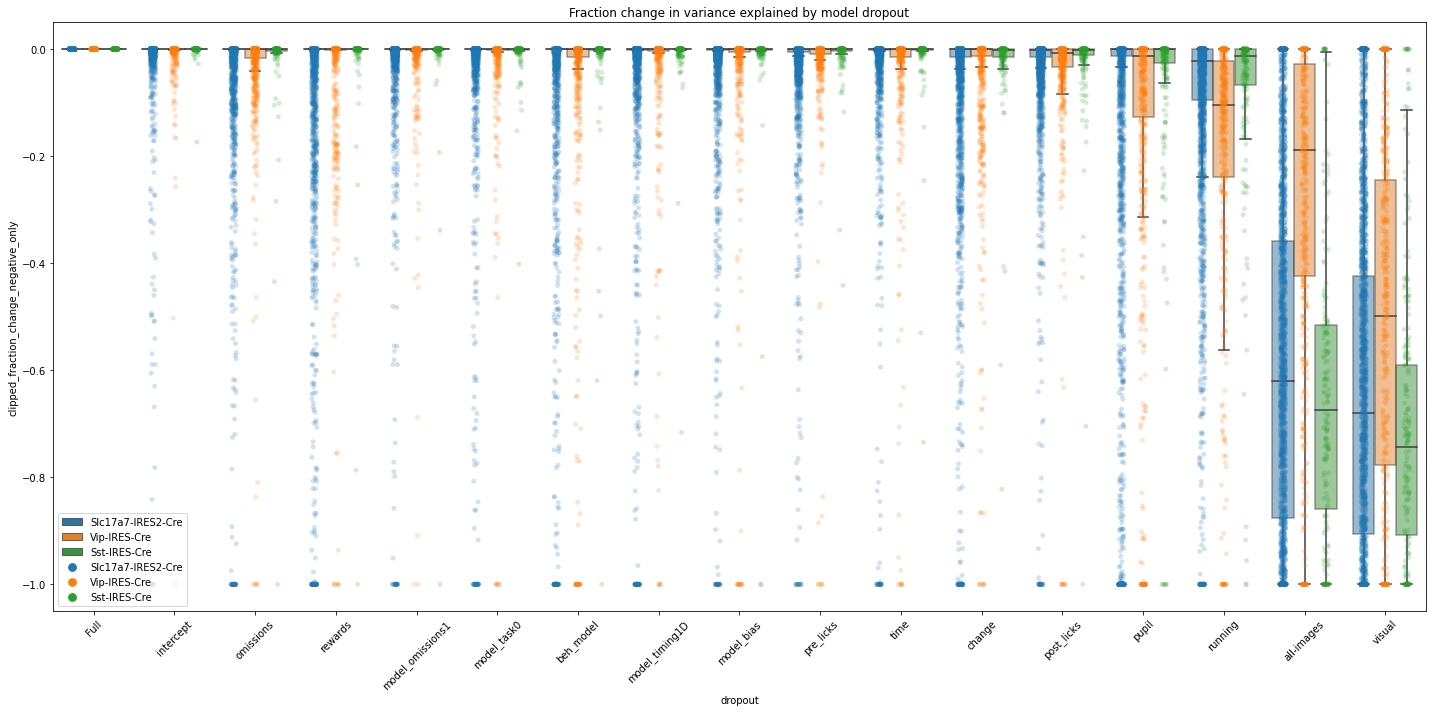

In [38]:
fig,ax=plt.subplots(figsize=(20,10))
bp = sns.boxplot(
    data = results_summary.query('dropout not in @kernels_to_exclude and above_CV_threshold'),
    x = 'dropout',
    y = 'clipped_fraction_change_negative_only',
    order=fraction_change_order_negative_only_limited,
    hue='cre_line',
    hue_order=genotype_order,
    ax=ax,
    fliersize=0,
    boxprops=dict(alpha=.5)
)

sp = sns.stripplot(
    data = results_summary.query('dropout not in @kernels_to_exclude').sample(50000),
    x = 'dropout',
    y = 'clipped_fraction_change_negative_only',
    order=fraction_change_order_negative_only_limited,
    hue='cre_line',
    hue_order=genotype_order,
    ax=ax,
    dodge=True,
    alpha=0.2
)
sp.legend(loc='lower left')
sp.set_xticklabels(labels=fraction_change_order_negative_only_limited, rotation=45)
ax.set_title('Fraction change in variance explained by model dropout')

fig.tight_layout()

## just a little stats exploration

In [24]:
scikit_posthocs.posthoc_mannwhitney(
    results_summary.query('dropout == "visual" and above_CV_threshold'),
    val_col='clipped_fraction_change_negative_only',
    group_col='cre_line',
    p_adjust='bonferroni'
)

,Slc17a7-IRES2-Cre,Sst-IRES-Cre,Vip-IRES-Cre
Slc17a7-IRES2-Cre,-1.000000e+00,4.290774e-13,2.229353e-62
Sst-IRES-Cre,4.290774e-13,-1.000000e+00,1.015583e-70
Vip-IRES-Cre,2.229353e-62,1.015583e-70,-1.000000e+00


In [25]:
scikit_posthocs.posthoc_mannwhitney(
    results_summary.query('dropout == "intercept" and above_CV_threshold'),
    val_col='clipped_fraction_change_negative_only',
    group_col='cre_line',
    p_adjust='bonferroni'
)

,Slc17a7-IRES2-Cre,Sst-IRES-Cre,Vip-IRES-Cre
Slc17a7-IRES2-Cre,-1.000000,0.017561,0.095188
Sst-IRES-Cre,0.017561,-1.000000,0.000428
Vip-IRES-Cre,0.095188,0.000428,-1.000000


In [26]:
scikit_posthocs.posthoc_mannwhitney(
    results_summary.query('dropout == "running" and above_CV_threshold'),
    val_col='clipped_fraction_change_negative_only',
    group_col='cre_line',
#     p_adjust='bonferroni'
)

,Slc17a7-IRES2-Cre,Sst-IRES-Cre,Vip-IRES-Cre
Slc17a7-IRES2-Cre,-1.000000e+00,8.573353e-07,1.716508e-117
Sst-IRES-Cre,8.573353e-07,-1.000000e+00,3.184420e-85
Vip-IRES-Cre,1.716508e-117,3.184420e-85,-1.000000e+00


/home/dougo/.conda/envs/visual_behavior/lib/python3.8/site-packages/seaborn-0.10.1-py3.8.egg/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/dougo/.conda/envs/visual_behavior/lib/python3.8/site-packages/seaborn-0.10.1-py3.8.egg/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/dougo/.conda/envs/visual_behavior/lib/python3.8/site-packages/seaborn-0.10.1-py3.8.egg/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


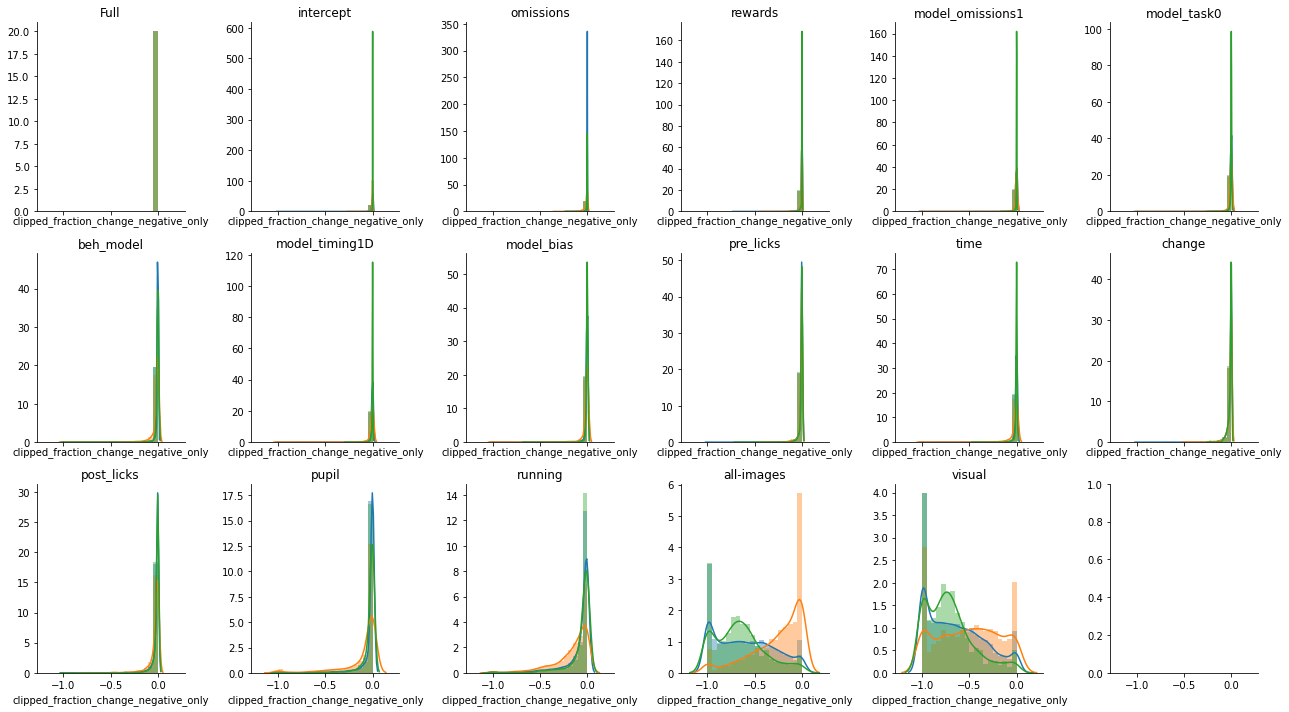

In [27]:
fig,ax=plt.subplots(3,6,figsize=(18,10),sharex=True, sharey=False)
for ii,dropout in enumerate(fraction_change_order_negative_only_limited):
    for cre_line in genotype_order:
        data_to_plot = results_summary.query("dropout == '{}' and cre_line == '{}' and above_CV_threshold".format(dropout, cre_line))
        sns.distplot(
            data_to_plot['clipped_fraction_change_negative_only'],
            ax=ax.flatten()[ii],
            norm_hist=True,
            bins=np.arange(-1,0.1,0.05),
        )
    ax.flatten()[ii].set_title(dropout)
sns.despine()
fig.tight_layout()

## split by imaging depth. But how?

In [28]:
results_summary['imaging_depth'].unique()

array([375, 175,  75, 300, 225, 150, 371,  81, 373, 377, 167,  83, 269,
        77,  85,  73, 165, 363,  79, 359,  67, 367, 279, 379,  69, 171,
       169, 361, 259, 181, 282, 271, 275, 267, 276, 302, 284, 274, 263,
       221, 298, 146,  71, 223, 219, 148, 270, 215, 154, 218, 312, 156,
       144, 227, 229, 308, 152, 217, 365, 273, 381, 261, 290, 292, 283,
       277, 355, 183,  95, 291, 369, 281, 179, 173, 310,  70, 320, 285,
       145, 321,  76, 149, 287, 228, 286, 316, 132, 294, 296, 350,  65,
       352])

### choose some arbitrary thresholds on image depth. I'm sure there's a better way, but good for now

(0.0, 0.03)

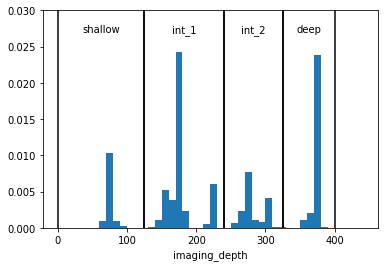

In [29]:
fig,ax=plt.subplots()
ax.hist(results_summary['imaging_depth'],bins=np.arange(0,450,10),density=True)
ax.set_xlabel('imaging_depth')
groups_by_depth = {
    'shallow':(0,125),
    'int_1':(125,240),
    'int_2':(240,325),
    'deep':(325,400)
}
for name,boundaries in groups_by_depth.items():
    ax.axvline(boundaries[0],color='black')
    ax.axvline(boundaries[1],color='black')
    
    ax.text(boundaries[0] + (boundaries[1] - boundaries[0])/2, 0.027, name, ha='center')
ax.set_ylim(0,0.03)

In [30]:
def assign_depth_category(depth,groups_by_depth):
    for name,boundaries in groups_by_depth.items():
        if depth > boundaries[0] and depth < boundaries[1]:
            return name
        
experiments_table['depth_bin'] = experiments_table['imaging_depth'].map(lambda depth:assign_depth_category(depth, groups_by_depth))
results_summary = results_summary.merge(
    experiments_table.reset_index()[['ophys_experiment_id','depth_bin']],
    left_on = 'ophys_experiment_id',
    right_on = 'ophys_experiment_id',
    how='left'
)

In [31]:
results_summary[['ophys_experiment_id','targeted_structure','depth_bin']].drop_duplicates().groupby('targeted_structure')['depth_bin'].value_counts()

targeted_structure  depth_bin
VISl                int_1         84
                    int_2         59
                    shallow       50
                    deep          19
VISp                int_1        170
                    int_2         93
                    deep          82
                    shallow       54
Name: depth_bin, dtype: int64

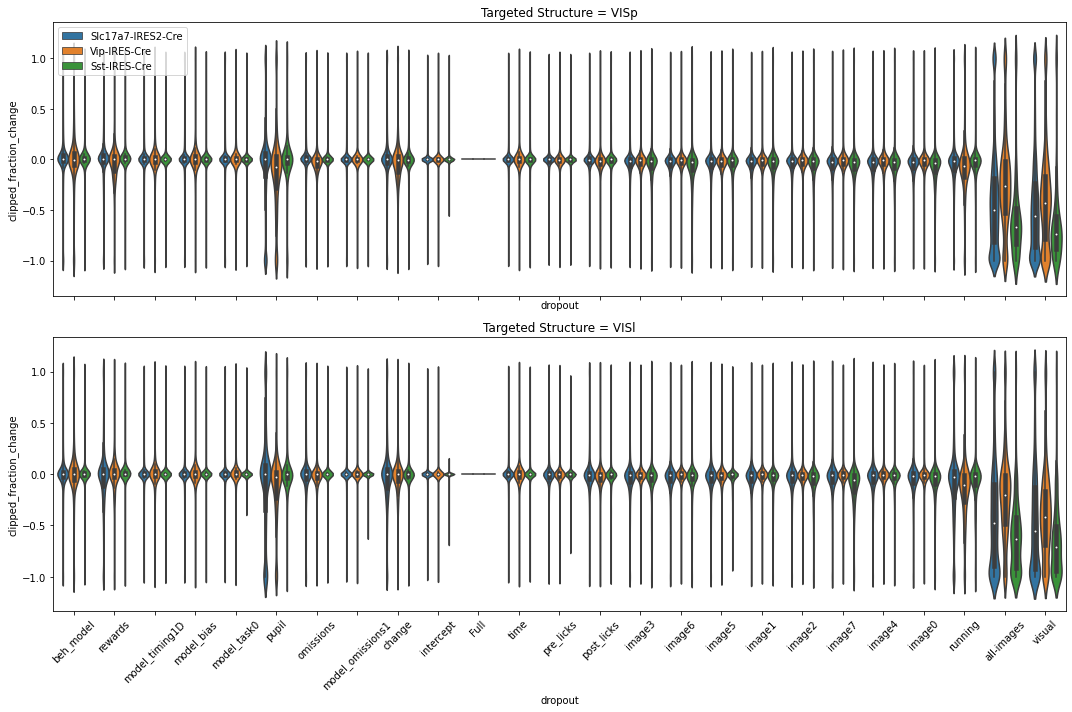

In [32]:
fig,ax=plt.subplots(2,1,figsize=(15,10),sharex=True)
row = 0
for _,structure in enumerate(['VISp','VISl']):
    results_to_plot = results_summary.query('targeted_structure == @structure')

    vp = sns.violinplot(
        data = results_to_plot,
        x = 'dropout',
        y = 'clipped_fraction_change',
        order=fraction_change_order,
        hue='cre_line',
        hue_order = genotype_order,
        scale='width',
        ax=ax[row],
    )
    ax[row].set_title('Targeted Structure = {}'.format(structure))
    if row != 0:
        vp.legend_.remove()
    else:
        vp.legend(loc='upper left')
    row += 1
    
vp.set_xticklabels(labels=fraction_change_order, rotation=45)
fig.tight_layout()

## split by both structure and depth!!

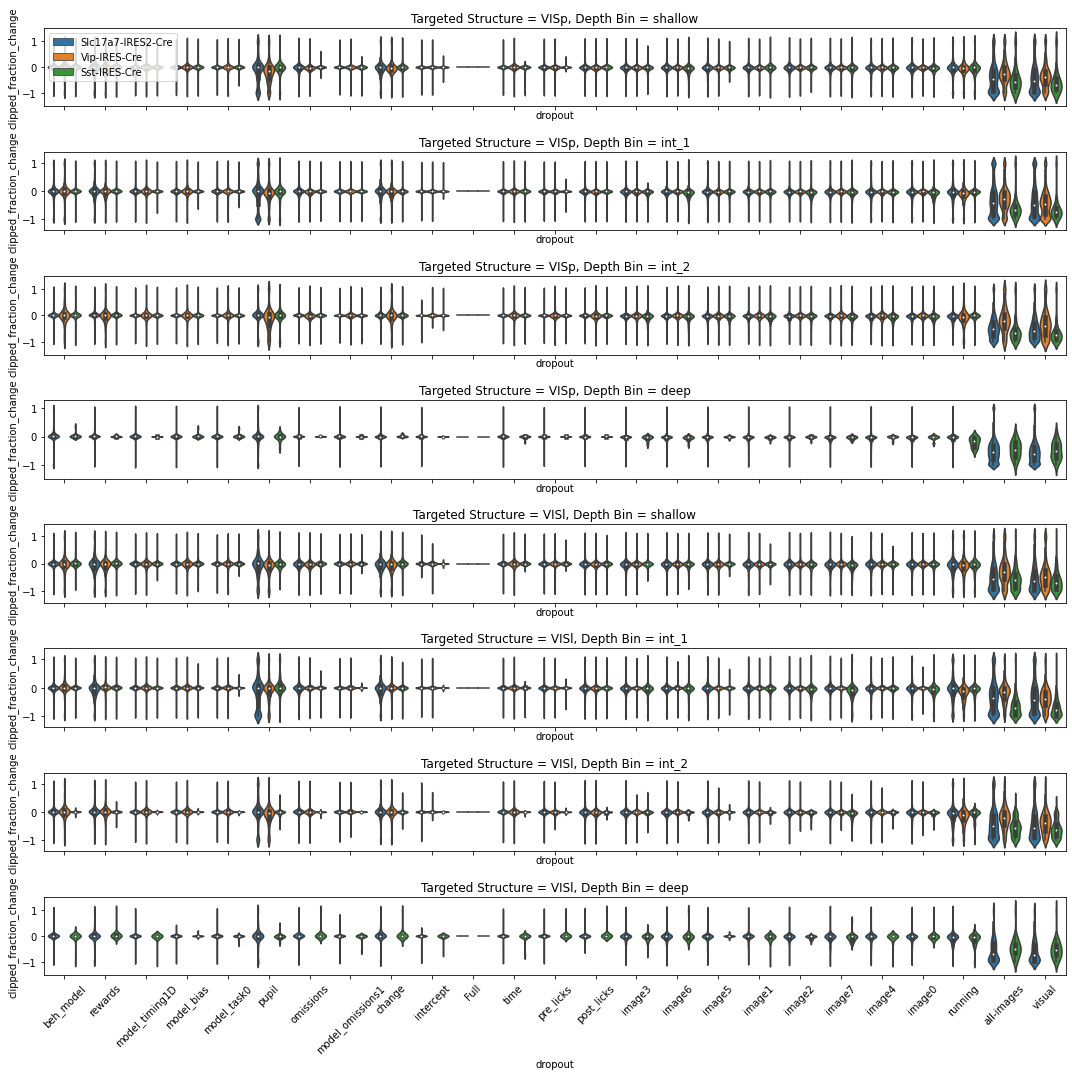

In [33]:
fig,ax=plt.subplots(8,1,figsize=(15,15),sharex=True)
row = 0
for _,structure in enumerate(['VISp','VISl']):
    for _, depth in enumerate(['shallow','int_1','int_2','deep']):
        results_to_plot = results_summary.query('targeted_structure == @structure and depth_bin == @depth')
        
        vp = sns.violinplot(
            data = results_to_plot,
            x = 'dropout',
            y = 'clipped_fraction_change',
            order=fraction_change_order,
            hue='cre_line',
            hue_order=genotype_order,
            scale='width',
            ax=ax[row],
        )
        ax[row].set_title('Targeted Structure = {}, Depth Bin = {}'.format(structure, depth))
        if row != 0:
            vp.legend_.remove()
        else:
            vp.legend(loc='upper left')
        row += 1
    
vp.set_xticklabels(labels=fraction_change_order, rotation=45)
fig.tight_layout()

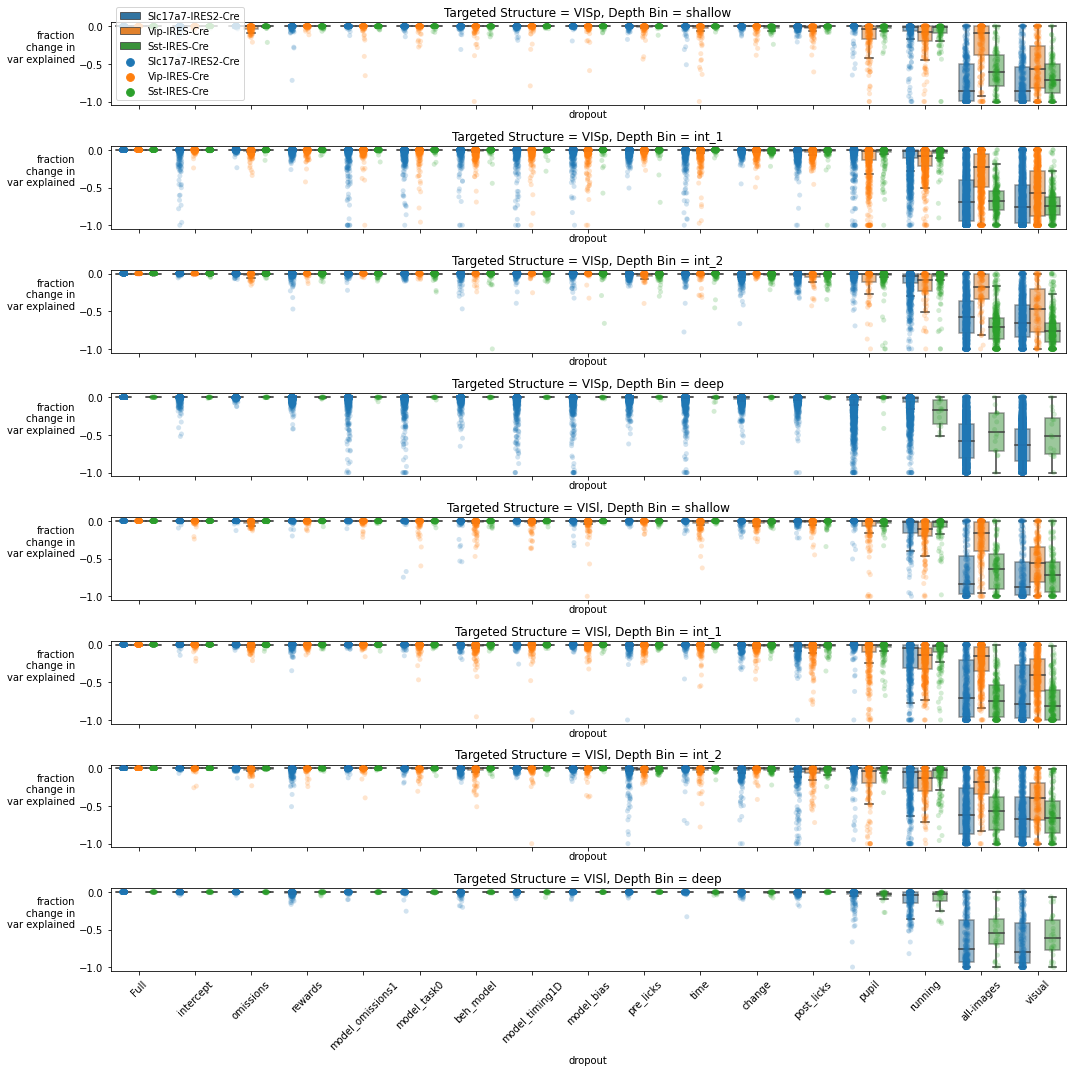

In [34]:
fig,ax=plt.subplots(8,1,figsize=(15,15),sharex=True)
row = 0
for _,structure in enumerate(['VISp','VISl']):
    for _, depth in enumerate(['shallow','int_1','int_2','deep']):
        
        bp = sns.boxplot(
            data = results_summary.query('targeted_structure == @structure and depth_bin == @depth and dropout not in @kernels_to_exclude and above_CV_threshold'),
            x = 'dropout',
            y = 'clipped_fraction_change_negative_only',
            order=fraction_change_order_negative_only_limited,
            hue='cre_line',
            hue_order=genotype_order,
            ax=ax[row],
            fliersize=0,
            boxprops=dict(alpha=.5)
        )

        sp = sns.stripplot(
            data = results_summary.query('targeted_structure == @structure and depth_bin == @depth and dropout not in @kernels_to_exclude and above_CV_threshold'),
            x = 'dropout',
            y = 'clipped_fraction_change_negative_only',
            order=fraction_change_order_negative_only_limited,
            hue='cre_line',
            hue_order=genotype_order,
            ax=ax[row],
            dodge=True,
            alpha=0.2
        )
#         sp.legend(loc='lower left')
        sp.set_xticklabels(labels=fraction_change_order_negative_only_limited, rotation=45)
        ax[row].set_title('Targeted Structure = {}, Depth Bin = {}'.format(structure, depth))
        ax[row].set_ylabel('fraction\nchange in\nvar explained',rotation=0,ha='right')
        
        if row != 0:
            sp.legend_.remove()
        else:
            sp.legend(loc='lower left')
        row += 1

fig.tight_layout()

## look at the distribution of variance explained for all cells by cre line

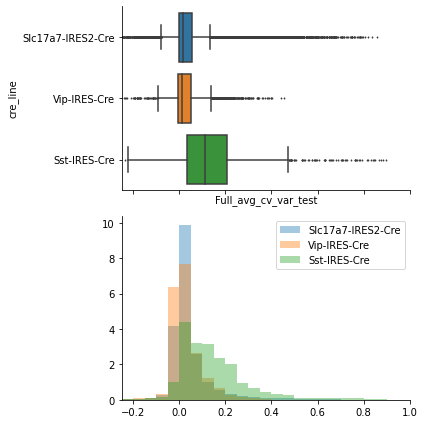

In [35]:
fig,ax=plt.subplots(2,1,figsize=(6,6),sharex=True)
for cre_line in genotype_order:
    data_to_plot = results_full.query("cre_line == '{}'".format(cre_line))
    sns.distplot(
        data_to_plot['Full_avg_cv_var_test'],
        ax=ax[1],
        norm_hist=True,
        bins=np.arange(-1,1,0.05),
        kde=False,
    )
sns.boxplot(
    data = results_full,
    x = 'Full_avg_cv_var_test',
    y = 'cre_line',
    order = genotype_order,
    fliersize=1,
    ax=ax[0]
)
ax[1].legend(genotype_order)
sns.despine()
ax[0].set_xlim(-0.25,1)
ax[1].set_xlabel('variance explained by full model')
ax[1].set_xlabel('')
fig.tight_layout()

In [36]:
results_full.groupby('cre_line')['above_CV_threshold'].value_counts()

cre_line           above_CV_threshold
Slc17a7-IRES2-Cre  True                  17133
                   False                 11550
Sst-IRES-Cre       True                   1322
                   False                   209
Vip-IRES-Cre       True                   2048
                   False                  1949
Name: above_CV_threshold, dtype: int64

In [37]:
results_full.groupby('cre_line')['above_CV_threshold'].value_counts(normalize=True)

cre_line           above_CV_threshold
Slc17a7-IRES2-Cre  True                  0.597322
                   False                 0.402678
Sst-IRES-Cre       True                  0.863488
                   False                 0.136512
Vip-IRES-Cre       True                  0.512384
                   False                 0.487616
Name: above_CV_threshold, dtype: float64